In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,MaxAbsScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate

In [2]:
df = pd.read_csv('./raw data/1000_sampled_data.csv')

In [3]:
df.sample(100)

,Company,Name,Inches,Screen_Resolution,CPU,RAM,Memory,GPU,OpSys,Weights,Price
285,HP,"2021 Newest HP 14 inches HD Laptop PC, Ryzen 3...",14 Inches,‎1366X768 Pixels,Ryzen 3 2200U,16 GB,512 GB,‎AMD Radeon Vega 3,‎Windows 10 Pro,‎3.33 pounds,NaN
695,Acer,"Acer Aspire 5 Slim Laptop, 15.6 Inches FHD IPS...",15.6 Inches,‎1920 x 1080,Core i5,8 GB,256 GB,‎Integrated,‎Windows 10 Home,‎3.97 pounds,$629.00
913,HP,"HP EliteBook 845 G8 14"" Touchscreen Notebook -...",14 Inches,‎1920 x 1080 Pixels,‎2.3 GHz,16 GB,256 GB,‎AMD Radeon Graphics,‎Windows 10 Pro,‎3.02 pounds,NaN
358,Acer,"Acer Swift 3-14"" Laptop Intel Core i5-1240P 1....",14 Inches,NaN,NaN,16 GB,512 GB,NaN,NaN,NaN,$679.99
942,HP,"HP 14 Laptop, Intel Celeron N4020, 4 GB RAM, 6...",14 Inches,‎1366 x 768 Pixels,Celeron N4020,4 GB,‎SSD,‎Intel UHD Graphics 600,‎Windows 11 Home,‎3.24 pounds,$212.78
...,...,...,...,...,...,...,...,...,...,...,...
182,Durabook,"Durabook Z14I, Fully Rugged Laptop, i7-1165G7,...",14 Inches,‎1920 x 1080 Pixels,Intel Core i7,16 GB,512 GB,‎Intel Iris Xe Graphics,‎Windows 10 Pro,NaN,"$3,999.99"
201,Dell,"Dell Inspiron 15 3525 Laptop (2022) | 15.6"" FH...",15.6 Inches,‎1920x1080 MP,AMD Ryzen 7,16 GB,512 GB,‎AMD Integrated Graphics,‎Windows 11 Home,‎8 pounds,$699.89
699,Dell,"Dell 2022 Newest Inspiron 3511 Laptop, 15.6"" F...",15.6 Inches,‎1920 x 1080 Pixels,Core i5 Family,16 GB,512 GB,‎Intel Iris Xe Graphics,‎Windows 11 Home,‎3.7 pounds,$532.97
618,Lenovo,Lenovo 20TA0025US Ts E14 G2 Ci7 8g 512g W10p,14 Inches,‎1920 x 1080 Pixels,Core i7,8 GB,‎SSD,NaN,‎Windows 10 Pro,‎3 pounds,$999.99


#### Missing values imputation and Create new feature

In [4]:
# Hàm trích xuất giá trị số từ chuỗi
def extract_memory_size(string):
    match = re.search(r'(\d+\.?\d*)\s*(?:TB|GB)', string)
    if match:
        return match.group()
    else:
        return None
# Hàm trích thay đổi giá trị từ TB sang TB    
def convert_to_gb(x):
    if isinstance(x, str):
        x = x.lower()
        if 'tb' in x:
            return int(float(x.replace('tb', '')) * 1024)
        elif 'gb' in x:
            return int(float(x.replace('gb', '')))
    return x
# Hàm xử lí giá trị trống    
def Impute_memory_missing_value(df, impute_method, df_train = None):
    df['Memory'] = df['Memory'].astype(str).replace('\.0', '', regex=True)

    df['Memory'] = df['Memory'].replace(["HDD", "SSD","Emmc","Flash Storage","Solid State Hard Drive","MB","flash_memory_solid_state","Serial ATA-600","Embedded MultiMediaCard"], '')
    
    df.loc[df['Memory'].str.contains('256GB PCIe M.2 SSD \+ 1TB \(\+8GB SSHD\) Hybrid Drive'), 'Memory'] = '1256GB'
    
    df['Memory'] = df['Memory'].apply(extract_memory_size)
    
    df['Memory'] = df['Memory'].apply(convert_to_gb)
    
    if df_train is None:
        if impute_method == 'mean':
            df['Memory'].fillna(df['Memory'].mean(), inplace=True)
        elif impute_method == 'mode':
            df['Memory'].fillna(df['Memory'].mode()[0], inplace=True)
        elif impute_method == 'median':
            df['Memory'].fillna(df['Memory'].median(), inplace=True)
        df['Memory'] = df['Memory'].astype(int)
        
    else:
        
        if impute_method == 'mean':
            df['Memory'].fillna(df_train['Memory'].mean(), inplace=True)
        elif impute_method == 'mode':
            df['Memory'].fillna(df_train['Memory'].mode()[0], inplace=True)
        elif impute_method == 'median':
            df['Memory'].fillna(df_train['Memory'].median(), inplace=True)
        df['Memory'] = df['Memory'].astype(int)    

    return df
    

In [5]:
def convert_to_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

def Impute_inches_missing_value(df, impute_method,df_train = None ):
    df['Inches'] = df['Inches'].str.replace('Inches','')
    
    df['Inches'] = df['Inches'].apply(convert_to_float)
    if df_train is None:
        if impute_method == 'mean':
            df['Inches'].fillna(df['Inches'].mean(), inplace=True)
        elif impute_method == 'mode':
            df['Inches'].fillna(df['Inches'].mode()[0], inplace=True)
        elif impute_method == 'median':
            df['Inches'].fillna(df['Inches'].median(), inplace=True)
    else:
        if impute_method == 'mean':
            df['Inches'].fillna(df_train['Inches'].mean(), inplace=True)
        elif impute_method == 'mode':
            df['Inches'].fillna(df_train['Inches'].mode()[0], inplace=True)
        elif impute_method == 'median':
            df['Inches'].fillna(df_train['Inches'].median(), inplace=True)
    
    return df

In [6]:
def try_convert_to_int(x):
    try:
        return int(x)
    except ValueError:
        return None

def Impute_screenres_missing_value(df, impute_method,df_train = None ):
    df['Screen_Resolution'] = df['Screen_Resolution'].str.replace('Pixels','').str.strip()
    
    df['X_res'] = df['Screen_Resolution'].str.split('[xX*]').str[0].str.strip()
    
    df['Y_res'] = df['Screen_Resolution'].str.split('[xX*]').str[1].str.strip()
    
    df['X_res'] = df['X_res'].apply(try_convert_to_int)
    
    df['Y_res'] = df['Y_res'].apply(try_convert_to_int)
    if df_train is None:
        if impute_method == 'mean':
            df['X_res'] = df['X_res'].fillna(df['X_res'].mean())
            
            df['Y_res'] = df['Y_res'].fillna(df['Y_res'].mean())
        elif impute_method == 'mode':
            df['X_res'] = df['X_res'].fillna(df['X_res'].mode()[0])
            
            df['Y_res'] = df['Y_res'].fillna(df['Y_res'].mode()[0])
        elif impute_method == 'median':
            df['X_res'] = df['X_res'].fillna(df['X_res'].median())
            
            df['Y_res'] = df['Y_res'].fillna(df['Y_res'].median())
    else:
        if impute_method == 'mean':
            df['X_res'] = df['X_res'].fillna(df_train['X_res'].mean())
            
            df['Y_res'] = df['Y_res'].fillna(df_train['Y_res'].mean())
        elif impute_method == 'mode':
            df['X_res'] = df['X_res'].fillna(df_train['X_res'].mode()[0])
            
            df['Y_res'] = df['Y_res'].fillna(df_train['Y_res'].mode()[0])
        elif impute_method == 'median':
            df['X_res'] = df['X_res'].fillna(df_train['X_res'].median())
            
            df['Y_res'] = df['Y_res'].fillna(df_train['Y_res'].median())
        
    df.drop(columns=['Screen_Resolution'],inplace=True)
    
    df['ppi'] = (((df['X_res']**2) + (df['Y_res']**2))**0.5/df['Inches']).astype('float')
    
    return df

In [7]:
def create_gaming_touchscreen_feature(df):
    
    df['Gaming'] = df['Name'].str.contains('Alienware|Gaming|Predator|ROG|MSI', case=False).astype(int)

    df['Touchscreen'] = df['Name'].str.contains('Touchscreen', case=False).astype(int)
    
    df.drop(columns=['Name'],inplace=True)
    return df

In [8]:
def fetch_processor(text):
    text = str(text)
    if 'Core i9' in text or 'Intel Core i9' in text:
        return 'Intel Core i9'
    elif 'Core i7' in text or 'Intel Core i7' in text:
        return 'Intel Core i7'
    elif 'Core i5' in text or 'Intel Core i5' in text:
        return 'Intel Core i5' 
    elif 'Core i3' in text or 'Intel Core i3' in text:
        return 'Intel Core i3'  
    else:
        if text.split()[0] == 'Intel':
            return 'Other Intel Processor'
        elif 'AMD' in text or 'Ryzen' in text:
            return 'AMD Processor'
        elif 'celeron' in text or 'Celeron' in text:
            return 'Celeron Processor'
        elif 'Pentium' in text or 'Pentium' in text:
            return 'Pentium Processor'
        elif 'Athlon' in text or 'athlon' in text:
            return 'Athlon Processor'
        else :
            return None
        
def Impute_cpu_missing_value(df,df_train = None):
    df['Cpu Brand'] = df['CPU'].apply(fetch_processor)
    
    if df_train is None:
        df['Cpu Brand'] = df['Cpu Brand'].fillna(df['Cpu Brand'].mode()[0])
    else:
        
        df['Cpu Brand'] = df['Cpu Brand'].fillna(df_train['Cpu Brand'].mode()[0])
    df.drop(columns=['CPU'],inplace=True)
    
    return df

In [10]:

def fetch_gpu(text):
    text = str(text)
    if 'Intel' in text or 'UHD' in text or  'HD' in text:
        return 'Intel '
    elif 'AMD' in text or 'Radeon' in text:
        return 'AMD'
    elif 'NVIDIA' in text or 'GTX' in text or 'RTX' in text:
        return 'NVIDIA'   
    else:
        return None
    
def Impute_gpu_missing_value(df,df_train = None):
    
    df['Gpu brand'] = df['GPU'].apply(fetch_gpu)
    if df_train is None:
        df['Gpu brand'] = df['Gpu brand'].fillna(df['Gpu brand'].mode()[0])
    else:
        
        df['Gpu brand'] = df['Gpu brand'].fillna(df_train['Gpu brand'].mode()[0])
    
    df.drop(columns=['GPU'],inplace=True)
    
    return df

In [11]:
def Impute_ram_missing_value(df, impute_method,df_train = None ):
    df['RAM'] = df['RAM'].astype(float).fillna(0).astype(int)
    if df_train is None:
        if impute_method == 'mean':
            df['RAM'] = df['RAM'].replace(0, df['RAM'].mean())
        elif impute_method == 'mode':
            df['RAM'] = df['RAM'].replace(0, df['RAM'].mode()[0])
        elif impute_method == 'median':
            df['RAM'] = df['RAM'].replace(0, df['RAM'].median())
    else:
        if impute_method == 'mean':
            df['RAM'] = df['RAM'].replace(0, df_train['RAM'].mean())
        elif impute_method == 'mode':
            df['RAM'] = df['RAM'].replace(0, df_train['RAM'].mode()[0])
        elif impute_method == 'median':
            df['RAM'] = df['RAM'].replace(0, df_train['RAM'].median())
    df['RAM']=df['RAM'].astype(int)
    return df

In [12]:
def fetch_opsys(text):
    text = str(text)
    if 'Chrome' in text:
        return 'Chrome OS'
    elif 'Windows' in text:
        return 'Windows'  
    else:
        return 'Others/Linux/Mac OS'
    
def Impute_opsys_missing_value(df):
    
    df['OpSys'] = df['OpSys'].apply(fetch_opsys)
    
    return df

In [13]:
def Impute_weights_missing_value(df,impute_method,df_train = None):
    
    df['Weights'] = df['Weights'].astype(float)
    if df_train is None:
        if impute_method == 'mean':
            df['Weights'] = df['Weights'].fillna(df['Weights'].mean())
        elif impute_method == 'mode':
            df['Weights'] = df['Weights'].fillna(df['Weights'].mode()[0])
        elif impute_method == 'median':
            df['Weights'] = df['Weights'].fillna(df['Weights'].median())
    else:
        if impute_method == 'mean':
            df['Weights'] = df['Weights'].fillna(df_train['Weights'].mean())
        elif impute_method == 'mode':
            df['Weights'] = df['Weights'].fillna(df_train['Weights'].mode()[0])
        elif impute_method == 'median':
            df['Weights'] = df['Weights'].fillna(df_train['Weights'].median())
    
    return df

In [14]:

def Clean_price(df,impute_method):
    
    df['Price'] = df['Price'].str.replace(',', '')
    df['Price'] = df['Price'].str.replace('$', '').str.replace('From', '').replace(',', '.').str.strip()
    df['Price'].replace('Unavailable', np.nan, inplace=True)
    df['Price'] = df['Price'].astype(float)
    
    if impute_method == 'mean':
        df['Price'].fillna(df['Price'].mean(), inplace=True)

    elif impute_method == 'mode':
        df['Price'].fillna(df['Price'].mode()[0], inplace=True)
        
    elif impute_method == 'median':
        df['Price'].fillna(df['Price'].median(), inplace=True)
    
    return df


In [15]:
def fetch_company(text):
    text = str(text)
    if 'Dell' in text or 'DELL' in text:
        return 'Dell'
    elif 'MSI' in text:
        return 'MSI'
    elif 'HP' in text or 'Hp' in text:
        return 'HP'   
    elif 'Acer' in text or 'ACER' in text:
        return 'Acer'   
    elif 'Razer' in text or 'RAZER' in text:
        return 'Razer'
    elif 'Apple' in text:
        return 'Apple'
    elif 'Lenovo' in text or 'LENOVO' in text:
        return 'Lenovo'
    elif 'ASUS' in text or 'Asus' in text or 'VivoBook' in text:
        return 'Asus'
    else:
        return 'Other'
    
def clean_company_data(df):
    
    df['Company'] = df['Company'].apply(fetch_company)
    
    return df

In [16]:
df_small = pd.read_csv('./raw data/1000_sampled_data.csv')
df_small = df_small.applymap(lambda x: x.replace('\u200e', '') if isinstance(x, str) else x)
df_small = Clean_price(df_small,'mean')
df_small['Inches'] = df_small['Inches'].str.replace('Inches','')
df_small['Screen_Resolution'] = df_small['Screen_Resolution'].str.replace('Pixels','').str.strip()
df_small['RAM'] = df_small['RAM'].str.extract('(\d+)')
df_small['Weights'] = df_small['Weights'].str.replace('pounds', '').str.replace('ounces', '').str.strip()

In [17]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            1000 non-null   object 
 1   Name               1000 non-null   object 
 2   Inches             976 non-null    object 
 3   Screen_Resolution  868 non-null    object 
 4   CPU                953 non-null    object 
 5   RAM                989 non-null    object 
 6   Memory             977 non-null    object 
 7   GPU                843 non-null    object 
 8   OpSys              966 non-null    object 
 9   Weights            948 non-null    object 
 10  Price              1000 non-null   float64
dtypes: float64(1), object(10)
memory usage: 86.1+ KB


In [18]:
df_big = pd.read_csv('./raw data/10000_data.csv')

In [19]:
df_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10305 entries, 0 to 10304
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            10305 non-null  object 
 1   Name               10305 non-null  object 
 2   Inches             10190 non-null  object 
 3   Screen_Resolution  9281 non-null   object 
 4   CPU                9992 non-null   object 
 5   RAM                10241 non-null  float64
 6   Memory             9585 non-null   object 
 7   GPU                8675 non-null   object 
 8   OpSys              10083 non-null  object 
 9   Weights            9068 non-null   float64
 10  Price              10305 non-null  float64
dtypes: float64(3), object(8)
memory usage: 885.7+ KB


In [45]:
from sklearn.model_selection import train_test_split
X_small = df_small.drop(columns=['Price'])
y_small = np.log(df_small['Price'])
X_train_s,X_test_s,y_train_s,y_test_s = train_test_split(X_small,y_small,test_size=0.3)
X_test_s, X_val_s, y_test_s, y_val_s = train_test_split(X_test_s, y_test_s, test_size=0.5, random_state=2)

In [46]:

X_big = df_big.drop(columns=['Price'])
y_big = np.log(df_big['Price'])
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X_big,y_big,test_size=0.3,random_state=2)
X_test_b, X_val_b, y_test_b, y_val_b = train_test_split(X_test_b, y_test_b, test_size=0.5, random_state=2)

#### Tìm phương pháp thay thế dữ liệu trống trên tập small data

In [333]:
result1 = pd.DataFrame(columns=['Memory','Inches','Screenres', 'Ram','Weights','Average r2 score'])
impute_methods = ['mean', 'median', 'mode']
for memory in impute_methods:
    for inches in impute_methods:
        for screenres in impute_methods:
            for ram in impute_methods:
                for weights in impute_methods:
                    X_new = X_small.copy()
                    y_new = y_small.copy()
                    X_new = Impute_memory_missing_value(X_new, memory)
                    X_new = Impute_inches_missing_value(X_new, inches)
                    X_new = Impute_screenres_missing_value(X_new,screenres)
                    X_new = create_gaming_touchscreen_feature(X_new)
                    X_new = Impute_cpu_missing_value(X_new)
                    X_new = Impute_gpu_missing_value(X_new)
                    X_new = Impute_ram_missing_value(X_new,ram)
                    X_new = Impute_opsys_missing_value(X_new)
                    X_new = Impute_weights_missing_value(X_new,weights)
                    X_new= clean_company_data(X_new)
                    
                    le = LabelEncoder()
                    X_new['Company'] = le.fit_transform(X_new['Company'])
                    X_new['OpSys'] = le.fit_transform(X_new['OpSys'])
                    X_new['Cpu Brand'] = le.fit_transform(X_new['Cpu Brand'])
                    X_new['Gpu brand'] = le.fit_transform(X_new['Gpu brand'])

                    model = RandomForestRegressor(n_estimators=100,
                                                random_state=3,
                                                max_samples=0.6,
                                                max_features=0.75,
                                                max_depth=15)

                    results = cross_validate(model, X_new, y_new, cv=5, scoring='r2')

                    average_r2 = np.mean(results['test_score'])
                    row = {'Memory': memory, 'Inches': inches,'Screenres': screenres, 'Ram': ram,'Weights': weights,'Average r2 score':average_r2 }
                    result1 = pd.concat([result1, pd.DataFrame([row])], ignore_index=True)

In [334]:
idx_max = result1['Average r2 score'].idxmax()

row = result1.loc[idx_max]

print(row)

Memory                median
Inches                  mean
Screenres             median
Ram                     mean
Weights                 mean
Average r2 score    0.527896
Name: 90, dtype: object


#### Tìm phương pháp thay thế dữ liệu trống trên tập big data

In [266]:


result = pd.DataFrame(columns=['Memory','Inches','Screenres', 'Ram','Weights','Average r2 score'])
impute_methods = ['mean', 'median', 'mode']
for memory in impute_methods:
    for inches in impute_methods:
        for screenres in impute_methods:
            for ram in impute_methods:
                for weights in impute_methods:
                    X_new = X_big.copy()
                    y_new = y_big.copy()
                    X_new = Impute_memory_missing_value(X_new, memory)
                    X_new = Impute_inches_missing_value(X_new, inches)
                    X_new = Impute_screenres_missing_value(X_new,screenres)
                    X_new = create_gaming_touchscreen_feature(X_new)
                    X_new = Impute_cpu_missing_value(X_new)
                    X_new = Impute_gpu_missing_value(X_new)
                    X_new = Impute_ram_missing_value(X_new,ram)
                    X_new = Impute_opsys_missing_value(X_new)
                    X_new = Impute_weights_missing_value(X_new,weights)
                    X_new= clean_company_data(X_new)
                    
                    le = LabelEncoder()
                    X_new['Company'] = le.fit_transform(X_new['Company'])
                    X_new['OpSys'] = le.fit_transform(X_new['OpSys'])
                    X_new['Cpu Brand'] = le.fit_transform(X_new['Cpu Brand'])
                    X_new['Gpu brand'] = le.fit_transform(X_new['Gpu brand'])

                    model = RandomForestRegressor(n_estimators=100,
                                                random_state=3,
                                                max_samples=0.6,
                                                max_features=0.75,
                                                max_depth=15)

                    results = cross_validate(model, X_new, y_new, cv=5, scoring='r2')

                    average_r2 = np.mean(results['test_score'])
                    row = {'Memory': memory, 'Inches': inches,'Screenres': screenres, 'Ram': ram,'Weights': weights,'Average r2 score':average_r2 }
                    result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

        


In [269]:
idx_max = result['Average r2 score'].idxmax()

row = result.loc[idx_max]

print(row)

Memory                  mean
Inches                median
Screenres               mean
Ram                     mean
Weights                 mode
Average r2 score    0.602805
Name: 29, dtype: object


In [267]:
result

,Memory,Inches,Screenres,Ram,Weights,Average r2 score
0,mean,mean,mean,mean,mean,0.592594
1,mean,mean,mean,mean,median,0.589773
2,mean,mean,mean,mean,mode,0.601832
3,mean,mean,mean,median,mean,0.589414
4,mean,mean,mean,median,median,0.583990
...,...,...,...,...,...,...
238,mode,mode,mode,median,median,0.577378
239,mode,mode,mode,median,mode,0.588518
240,mode,mode,mode,mode,mean,0.579309
241,mode,mode,mode,mode,median,0.577378


In [47]:
X_train_s = Impute_memory_missing_value(X_train_s,'median')
X_test_s = Impute_memory_missing_value(X_test_s,'median',X_train_s)
X_val_s = Impute_memory_missing_value(X_val_s,'median',X_train_s)

X_train_s = Impute_inches_missing_value(X_train_s,'mean')
X_test_s = Impute_inches_missing_value(X_test_s,'mean',X_train_s)
X_val_s = Impute_inches_missing_value(X_val_s,'mean',X_train_s)

X_train_s = Impute_screenres_missing_value(X_train_s,'median')
X_test_s = Impute_screenres_missing_value(X_test_s,'median',X_train_s)
X_val_s = Impute_screenres_missing_value(X_val_s,'median',X_train_s)

X_train_s = create_gaming_touchscreen_feature(X_train_s)
X_test_s = create_gaming_touchscreen_feature(X_test_s)
X_val_s = create_gaming_touchscreen_feature(X_val_s)

X_train_s = Impute_cpu_missing_value(X_train_s)
X_test_s = Impute_cpu_missing_value(X_test_s,X_train_s)
X_val_s = Impute_cpu_missing_value(X_val_s,X_train_s)

X_train_s = Impute_gpu_missing_value(X_train_s)
X_test_s = Impute_gpu_missing_value(X_test_s,X_train_s)
X_val_s = Impute_gpu_missing_value(X_val_s,X_train_s)

X_train_s = Impute_ram_missing_value(X_train_s,'mean')
X_test_s = Impute_ram_missing_value(X_test_s,'mean',X_train_s)
X_val_s = Impute_ram_missing_value(X_val_s,'mean',X_train_s)


X_train_s = Impute_opsys_missing_value(X_train_s)
X_test_s = Impute_opsys_missing_value(X_test_s)
X_val_s = Impute_opsys_missing_value(X_val_s)

X_train_s = Impute_weights_missing_value(X_train_s,'mean')
X_test_s = Impute_weights_missing_value(X_test_s,'mean',X_train_s)
X_val_s = Impute_weights_missing_value(X_val_s,'mean',X_train_s)

X_train_s= clean_company_data(X_train_s)
X_test_s= clean_company_data(X_test_s)
X_val_s= clean_company_data(X_val_s)



In [51]:
X_train_s.sample(100)

,Company,Inches,RAM,Memory,OpSys,Weights,X_res,Y_res,ppi,Gaming,Touchscreen,Cpu Brand,Gpu brand
810,Dell,13.300000,8,256,Windows,4.500000,1920.0,1080.0,165.632118,0,0,Intel Core i5,Intel
654,Lenovo,14.000000,16,256,Windows,4.270000,1920.0,1200.0,161.725391,0,0,Intel Core i5,Intel
701,Lenovo,15.600000,8,256,Windows,5.890000,1920.0,1200.0,145.138171,0,1,Intel Core i5,Intel
9,Asus,14.000000,8,256,Windows,4.510000,1920.0,1080.0,157.350512,0,0,Intel Core i5,Intel
878,HP,14.000000,32,2048,Windows,7.000000,1920.0,1200.0,161.725391,0,0,Intel Core i7,Intel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,HP,16.000000,16,2048,Windows,7.000000,3072.0,1920.0,226.415547,0,1,Intel Core i7,Intel
866,Other,14.000000,8,256,Windows,6.550000,1600.0,900.0,131.125427,0,0,Intel Core i7,Intel
558,Other,14.721508,15,512,Windows,5.007149,1920.0,1080.0,149.638689,0,0,Intel Core i7,Intel
915,Asus,15.600000,16,1024,Windows,5.700000,1920.0,1080.0,141.211998,1,0,Intel Core i7,NVIDIA


In [23]:
X_train_s.drop(columns=['X_res','Y_res'],inplace=True)
X_test_s.drop(columns=['X_res','Y_res'],inplace=True)
X_val_s.drop(columns=['X_res','Y_res'],inplace=True)

In [24]:
X_train_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 116 to 44
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      700 non-null    object 
 1   Inches       700 non-null    float64
 2   RAM          700 non-null    int32  
 3   Memory       700 non-null    int32  
 4   OpSys        700 non-null    object 
 5   Weights      700 non-null    float64
 6   ppi          700 non-null    float64
 7   Gaming       700 non-null    int32  
 8   Touchscreen  700 non-null    int32  
 9   Cpu Brand    700 non-null    object 
 10  Gpu brand    700 non-null    object 
dtypes: float64(3), int32(4), object(4)
memory usage: 54.7+ KB


In [52]:
X_train_b = Impute_memory_missing_value(X_train_b,'mean')
X_test_b = Impute_memory_missing_value(X_test_b,'mean',X_train_b)
X_val_b = Impute_memory_missing_value(X_val_b,'mean',X_train_b)

X_train_b = Impute_inches_missing_value(X_train_b,'median')
X_test_b = Impute_inches_missing_value(X_test_b,'median',X_train_b)
X_val_b = Impute_inches_missing_value(X_val_b,'median',X_train_b)

X_train_b = Impute_screenres_missing_value(X_train_b,'mean')
X_test_b = Impute_screenres_missing_value(X_test_b,'mean',X_train_b)
X_val_b = Impute_screenres_missing_value(X_val_b,'mean',X_train_b)

X_train_b = create_gaming_touchscreen_feature(X_train_b)
X_test_b = create_gaming_touchscreen_feature(X_test_b)
X_val_b = create_gaming_touchscreen_feature(X_val_b)

X_train_b = Impute_cpu_missing_value(X_train_b)
X_test_b = Impute_cpu_missing_value(X_test_b,X_train_b)
X_val_b = Impute_cpu_missing_value(X_val_b,X_train_b)

X_train_b = Impute_gpu_missing_value(X_train_b)
X_test_b = Impute_gpu_missing_value(X_test_b,X_train_b)
X_val_b = Impute_gpu_missing_value(X_val_b,X_train_b)

X_train_b = Impute_ram_missing_value(X_train_b,'mean')
X_test_b = Impute_ram_missing_value(X_test_b,'mean',X_train_b)
X_val_b = Impute_ram_missing_value(X_val_b,'mean',X_train_b)


X_train_b = Impute_opsys_missing_value(X_train_b)
X_test_b = Impute_opsys_missing_value(X_test_b)
X_val_b = Impute_opsys_missing_value(X_val_b)

X_train_b = Impute_weights_missing_value(X_train_b,'mode')
X_test_b = Impute_weights_missing_value(X_test_b,'mode',X_train_b)
X_val_b = Impute_weights_missing_value(X_val_b,'mode',X_train_b)

X_train_b= clean_company_data(X_train_b)
X_test_b= clean_company_data(X_test_b)
X_val_b= clean_company_data(X_val_b)



In [ ]:
X_train_b.drop(columns=['X_res','Y_res'],inplace=True)
X_test_b.drop(columns=['X_res','Y_res'],inplace=True)
X_val_b.drop(columns=['X_res','Y_res'],inplace=True)

In [27]:
X_train_b.sample(10)

,Company,Inches,RAM,Memory,OpSys,Weights,ppi,Gaming,Touchscreen,Cpu Brand,Gpu brand
6942,Lenovo,15.6,8,64,Chrome OS,5.59,141.211998,0,0,Celeron Processor,Intel
8804,Asus,14.0,8,512,Windows,3.00,157.350512,0,0,Intel Core i3,Intel
8895,HP,14.0,16,512,Windows,3.04,157.350512,0,0,AMD Processor,AMD
3743,Other,15.6,14,608,Windows,3.00,147.460993,0,0,Intel Core i7,Intel
1194,HP,14.0,8,256,Windows,1.00,131.125427,0,0,Intel Core i7,Intel
2548,MSI,15.6,16,608,Windows,6.85,147.460993,1,0,Intel Core i7,NVIDIA
3469,Other,17.3,32,1024,Windows,10.68,127.335675,0,0,Intel Core i9,NVIDIA
6728,Lenovo,15.6,8,64,Chrome OS,5.59,141.211998,0,0,Celeron Processor,Intel
330,Lenovo,17.3,8,1000,Windows,4.60,127.335675,0,0,Intel Core i5,Intel
1025,Asus,14.0,8,512,Windows,2.78,157.350512,0,0,Intel Core i5,Intel


In [57]:
X_train_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7213 entries, 7680 to 7336
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      7213 non-null   int32  
 1   Inches       7213 non-null   float64
 2   RAM          7213 non-null   int32  
 3   Memory       7213 non-null   int32  
 4   OpSys        7213 non-null   int32  
 5   Weights      7213 non-null   float64
 6   X_res        7213 non-null   float64
 7   Y_res        7213 non-null   float64
 8   ppi          7213 non-null   float64
 9   Gaming       7213 non-null   int32  
 10  Touchscreen  7213 non-null   int32  
 11  Cpu Brand    7213 non-null   int32  
 12  Gpu brand    7213 non-null   int32  
dtypes: float64(5), int32(8)
memory usage: 563.5 KB


In [29]:
X_small = Impute_memory_missing_value(X_small,'median')

X_small = Impute_inches_missing_value(X_small,'mean')

X_small = Impute_screenres_missing_value(X_small,'median')

X_small = create_gaming_touchscreen_feature(X_small)

X_small = Impute_cpu_missing_value(X_small)

X_small = Impute_gpu_missing_value(X_small)

X_small = Impute_ram_missing_value(X_small,'mean')

X_small = Impute_opsys_missing_value(X_small)

X_small = Impute_weights_missing_value(X_small,'mean')

X_small= clean_company_data(X_small)

le = LabelEncoder()
X_small['Company'] = le.fit_transform(X_small['Company'])
X_small['OpSys'] = le.fit_transform(X_small['OpSys'])
X_small['Cpu Brand'] = le.fit_transform(X_small['Cpu Brand'])
X_small['Gpu brand'] = le.fit_transform(X_small['Gpu brand'])

In [30]:
X_small.drop(columns=['X_res','Y_res'],inplace=True)

In [31]:
X_big = Impute_memory_missing_value(X_big,'mean')

X_big = Impute_inches_missing_value(X_big,'median')

X_big = Impute_screenres_missing_value(X_big,'mean')

X_big = create_gaming_touchscreen_feature(X_big)

X_big = Impute_cpu_missing_value(X_big)

X_big = Impute_gpu_missing_value(X_big)

X_big = Impute_ram_missing_value(X_big,'mean')

X_big = Impute_opsys_missing_value(X_big)

X_big = Impute_weights_missing_value(X_big,'mode')

X_big= clean_company_data(X_big)

X_big.drop(columns=['X_res','Y_res'],inplace=True)

le = LabelEncoder()
X_big['Company'] = le.fit_transform(X_big['Company'])
X_big['OpSys'] = le.fit_transform(X_big['OpSys'])
X_big['Cpu Brand'] = le.fit_transform(X_big['Cpu Brand'])
X_big['Gpu brand'] = le.fit_transform(X_big['Gpu brand'])

In [59]:
le = LabelEncoder()
X_train_s['Company'] = le.fit_transform(X_train_s['Company'])
X_train_s['OpSys'] = le.fit_transform(X_train_s['OpSys'])
X_train_s['Cpu Brand'] = le.fit_transform(X_train_s['Cpu Brand'])
X_train_s['Gpu brand'] = le.fit_transform(X_train_s['Gpu brand'])

X_train_b['Company'] = le.fit_transform(X_train_b['Company'])
X_train_b['OpSys'] = le.fit_transform(X_train_b['OpSys'])
X_train_b['Cpu Brand'] = le.fit_transform(X_train_b['Cpu Brand'])
X_train_b['Gpu brand'] = le.fit_transform(X_train_b['Gpu brand'])

X_test_b['Company'] = le.fit_transform(X_test_b['Company'])
X_test_b['OpSys'] = le.fit_transform(X_test_b['OpSys'])
X_test_b['Cpu Brand'] = le.fit_transform(X_test_b['Cpu Brand'])
X_test_b['Gpu brand'] = le.fit_transform(X_test_b['Gpu brand'])

X_test_s['Company'] = le.fit_transform(X_test_s['Company'])
X_test_s['OpSys'] = le.fit_transform(X_test_s['OpSys'])
X_test_s['Cpu Brand'] = le.fit_transform(X_test_s['Cpu Brand'])
X_test_s['Gpu brand'] = le.fit_transform(X_test_s['Gpu brand'])

X_val_s['Company'] = le.fit_transform(X_val_s['Company'])
X_val_s['OpSys'] = le.fit_transform(X_val_s['OpSys'])
X_val_s['Cpu Brand'] = le.fit_transform(X_val_s['Cpu Brand'])
X_val_s['Gpu brand'] = le.fit_transform(X_val_s['Gpu brand'])

X_val_b['Company'] = le.fit_transform(X_val_b['Company'])
X_val_b['OpSys'] = le.fit_transform(X_val_b['OpSys'])
X_val_b['Cpu Brand'] = le.fit_transform(X_val_b['Cpu Brand'])
X_val_b['Gpu brand'] = le.fit_transform(X_val_b['Gpu brand'])


Thử train mô hình trước sau khi tạo đặc trưng mới

In [60]:
X_test_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1546 entries, 8217 to 9964
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1546 non-null   int32  
 1   Inches       1546 non-null   float64
 2   RAM          1546 non-null   int32  
 3   Memory       1546 non-null   int32  
 4   OpSys        1546 non-null   int32  
 5   Weights      1546 non-null   float64
 6   X_res        1546 non-null   float64
 7   Y_res        1546 non-null   float64
 8   ppi          1546 non-null   float64
 9   Gaming       1546 non-null   int32  
 10  Touchscreen  1546 non-null   int32  
 11  Cpu Brand    1546 non-null   int32  
 12  Gpu brand    1546 non-null   int32  
dtypes: float64(5), int32(8)
memory usage: 120.8 KB


In [91]:
X_train_s_temp = X_train_s.drop(columns=['ppi'])
X_train_b_temp = X_train_b.drop(columns=['ppi'])
X_test_s_temp = X_test_s.drop(columns=['ppi'])
X_test_b_temp = X_test_b.drop(columns=['ppi'])
X_val_s_temp = X_val_s.drop(columns=['ppi'])
X_val_b_temp = X_val_b.drop(columns=['ppi'])

Trước khi tạo đặc trưng ppi

In [96]:

model = RandomForestRegressor(random_state=3)


model.fit(X_train_s_temp, y_train_s)
y_pred_val_s = model.predict(X_val_s_temp)
y_pred_test_s = model.predict(X_test_s_temp)


print("R2 score on test set:", r2_score(y_test_s,y_pred_test_s))

print("R2 score on validation set:", r2_score(y_val_s,y_pred_val_s))

print('Mean Squared Error test:', mean_squared_error(y_test_s, y_pred_test_s))

print('Mean Squared Error validation:', mean_squared_error(y_val_s, y_pred_val_s))

print('MAE test:',mean_absolute_error(y_test_s,y_pred_test_s))

print('MAE val:',mean_absolute_error(y_val_s,y_pred_val_s))

R2 score on test set: 0.4100591383867144
R2 score on validation set: 0.4977891047945824
Mean Squared Error test: 0.34771329467039164
Mean Squared Error validation: 0.2845323615877446
MAE test: 0.4040945918349208
MAE val: 0.38408823706075085


In [97]:

model.fit(X_train_b_temp, y_train_b)
y_pred_val_b = model.predict(X_val_b_temp)
y_pred_test_b = model.predict(X_test_b_temp)


print("R2 score on test set:", r2_score(y_test_b,y_pred_test_b))

print("R2 score on validation set:", r2_score(y_val_b,y_pred_val_b))

print('Mean Squared Error test:', mean_squared_error(y_test_b, y_pred_test_b))

print('Mean Squared Error validation:', mean_squared_error(y_val_b, y_pred_val_b))

print('MAE test:',mean_absolute_error(y_test_b,y_pred_test_b))

print('MAE val:',mean_absolute_error(y_val_b,y_pred_val_b))

R2 score on test set: 0.772435413184111
R2 score on validation set: 0.7859847165488478
Mean Squared Error test: 0.12239104889129326
Mean Squared Error validation: 0.1272057922123693
MAE test: 0.2044635303571395
MAE val: 0.21721233245670316


Sau khi tạo đặc trưng ppi

In [105]:
X_train_s_temp = X_train_s
X_train_b_temp = X_train_b
X_test_s_temp = X_test_s
X_test_b_temp = X_test_b
X_val_s_temp = X_val_s
X_val_b_temp = X_val_b

In [106]:

model.fit(X_train_s_temp, y_train_s)
y_pred_val_s = model.predict(X_val_s_temp)
y_pred_test_s = model.predict(X_test_s_temp)


print("R2 score on test set:", r2_score(y_test_s,y_pred_test_s))

print("R2 score on validation set:", r2_score(y_val_s,y_pred_val_s))

print('Mean Squared Error test:', mean_squared_error(y_test_s, y_pred_test_s))

print('Mean Squared Error validation:', mean_squared_error(y_val_s, y_pred_val_s))

print('MAE test:',mean_absolute_error(y_test_s,y_pred_test_s))

print('MAE val:',mean_absolute_error(y_val_s,y_pred_val_s))

R2 score on test set: 0.4043282139726133
R2 score on validation set: 0.4945028083633246
Mean Squared Error test: 0.35109112241414997
Mean Squared Error validation: 0.28639424410242137
MAE test: 0.40473631153881146
MAE val: 0.3866669888530105


In [107]:

model.fit(X_train_b_temp, y_train_b)
y_pred_val_b = model.predict(X_val_b_temp)
y_pred_test_b = model.predict(X_test_b_temp)


print("R2 score on test set:", r2_score(y_test_b,y_pred_test_b))

print("R2 score on validation set:", r2_score(y_val_b,y_pred_val_b))

print('Mean Squared Error test:', mean_squared_error(y_test_b, y_pred_test_b))

print('Mean Squared Error validation:', mean_squared_error(y_val_b, y_pred_val_b))

print('MAE test:',mean_absolute_error(y_test_b,y_pred_test_b))

print('MAE val:',mean_absolute_error(y_val_b,y_pred_val_b))

R2 score on test set: 0.7719321979941616
R2 score on validation set: 0.7847710536948767
Mean Squared Error test: 0.1226616930885197
Mean Squared Error validation: 0.12792716566910825
MAE test: 0.20507193261782722
MAE val: 0.21806757839088273


#### Lựa chọn đặc trưng quan trọng

Thử với thuật toán RandomForest trên tập small

In [35]:

rf = RandomForestRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=0.6,
                              max_features=0.75,
                              max_depth=15)

rf.fit(X_train_s, y_train_s)

feature_importances1 = pd.DataFrame(rf.feature_importances_, index=X_train_s.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances1)

top_features1 = feature_importances1.index[:6].tolist()
print(top_features1)

             importance
RAM            0.408134
Weights        0.142059
Memory         0.128501
ppi            0.071387
Cpu Brand      0.050839
Inches         0.050314
Company        0.050200
Gpu brand      0.033452
OpSys          0.031141
Touchscreen    0.028994
Gaming         0.004980
['RAM', 'Weights', 'Memory', 'ppi', 'Cpu Brand', 'Inches']


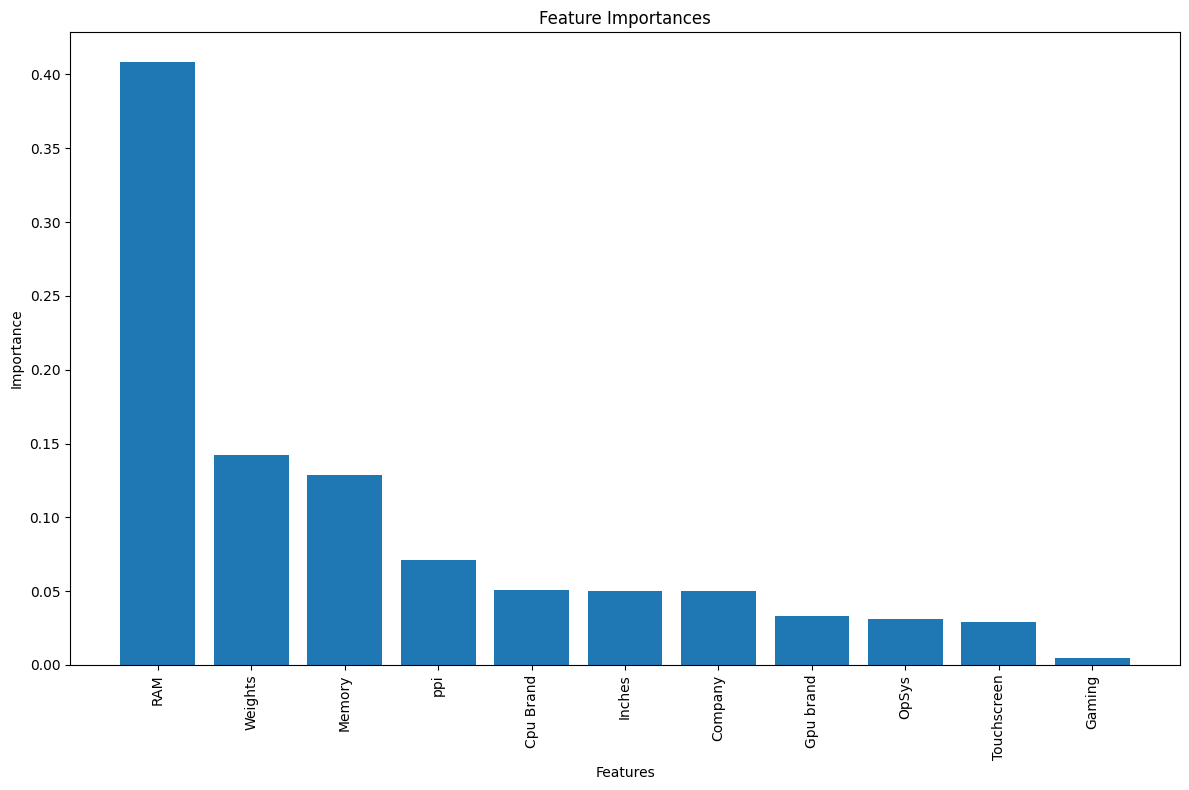

In [39]:
plt.figure(figsize=(12, 8))
plt.bar(feature_importances1.index, feature_importances1['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Thử với thuật toán RandomForest trên tập big

In [34]:

rf = RandomForestRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=0.6,
                              max_features=0.75,
                              max_depth=15)

rf.fit(X_train_b, y_train_b)

feature_importances2 = pd.DataFrame(rf.feature_importances_, index=X_train_b.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances2)

top_features2 = feature_importances2.index[:6].tolist()
print(top_features2)

             importance
RAM            0.300271
Memory         0.223021
Weights        0.117262
ppi            0.093402
Cpu Brand      0.088550
Inches         0.050696
Company        0.046254
OpSys          0.034224
Gpu brand      0.028076
Touchscreen    0.013193
Gaming         0.005050
['RAM', 'Memory', 'Weights', 'ppi', 'Cpu Brand', 'Inches']


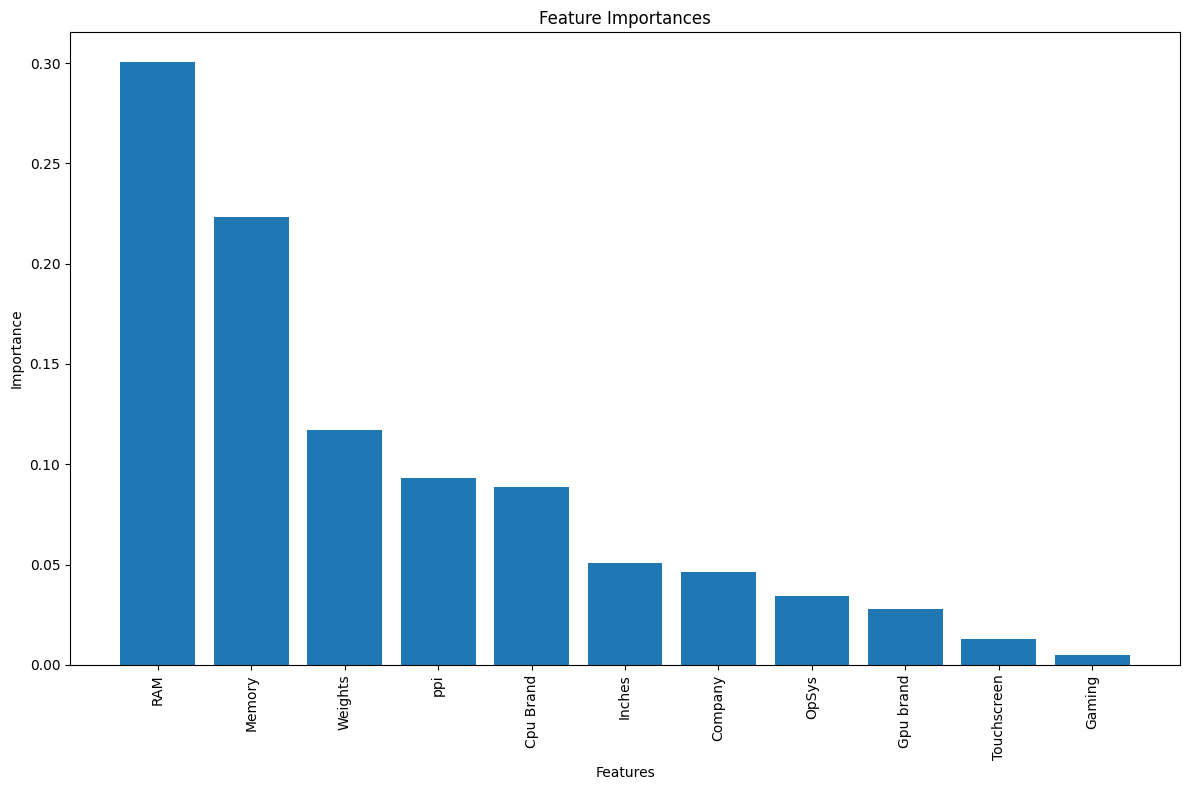

In [40]:
plt.figure(figsize=(12, 8))
plt.bar(feature_importances2.index, feature_importances2['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Thử với thuật toán GradientBoosting trên tập small

In [41]:
rf = GradientBoostingRegressor(n_estimators=100,random_state=3)

rf.fit(X_train_s, y_train_s)

feature_importances3 = pd.DataFrame(rf.feature_importances_, index=X_train_s.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances3)

top_features3 = feature_importances3.index[:6].tolist()
print(top_features3)

             importance
RAM            0.617053
Weights        0.094293
ppi            0.062224
Memory         0.057233
Gpu brand      0.039297
Cpu Brand      0.038181
Inches         0.028344
Company        0.025598
OpSys          0.023642
Touchscreen    0.011106
Gaming         0.003030
['RAM', 'Weights', 'ppi', 'Memory', 'Gpu brand', 'Cpu Brand']


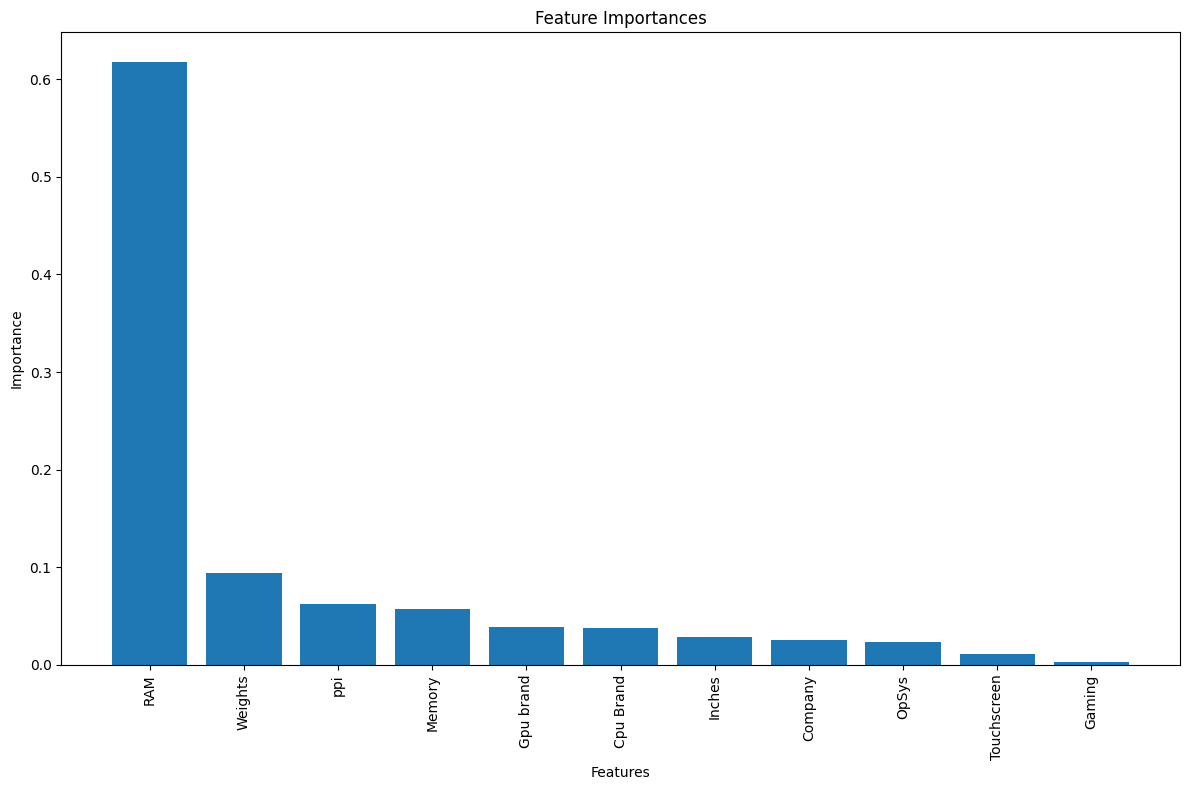

In [42]:
plt.figure(figsize=(12, 8))
plt.bar(feature_importances3.index, feature_importances3['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Thử với thuật toán GradientBoosting trên tập big

In [43]:
rf = GradientBoostingRegressor(n_estimators=100,random_state=3)

rf.fit(X_train_b, y_train_b)

feature_importances4 = pd.DataFrame(rf.feature_importances_, index=X_train_b.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances4)

top_features4 = feature_importances4.index[:6].tolist()
print(top_features4)

             importance
RAM            0.476675
Memory         0.195892
Cpu Brand      0.081092
ppi            0.080048
Weights        0.045942
Inches         0.043334
Gpu brand      0.038615
OpSys          0.019371
Company        0.011737
Touchscreen    0.007268
Gaming         0.000027
['RAM', 'Memory', 'Cpu Brand', 'ppi', 'Weights', 'Inches']


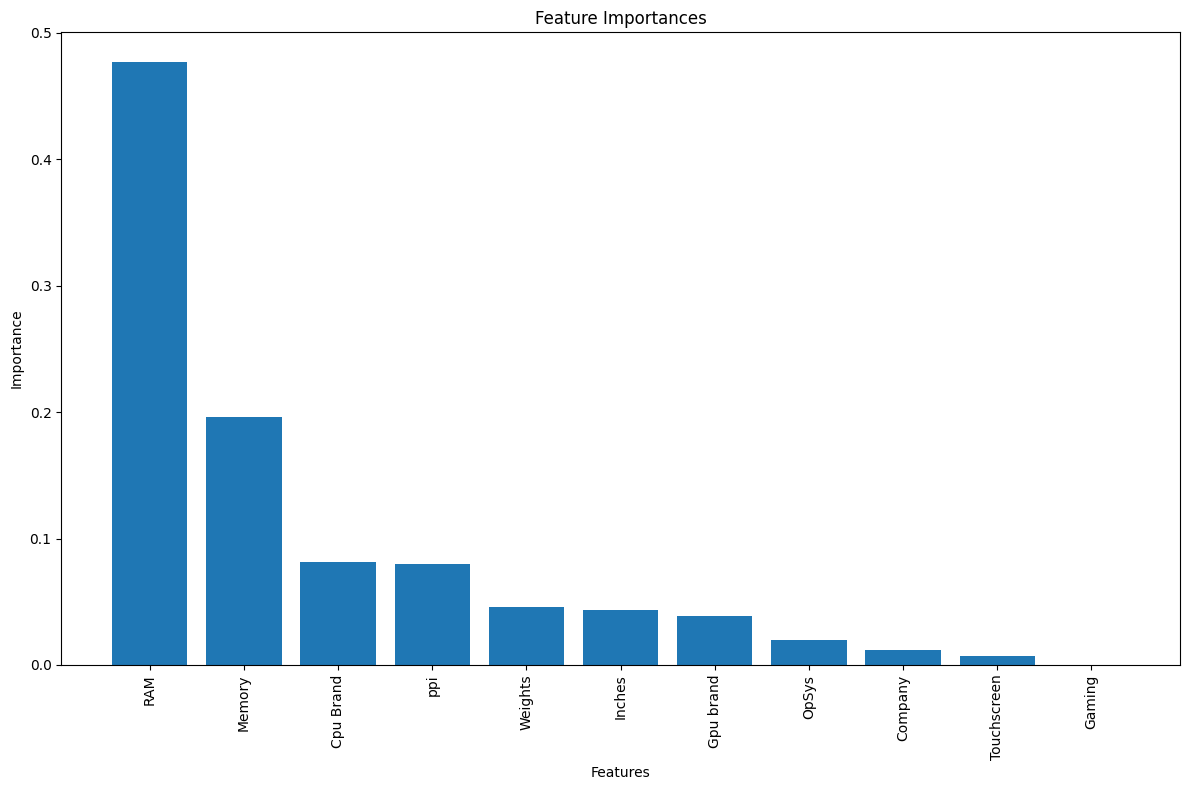

In [44]:
plt.figure(figsize=(12, 8))
plt.bar(feature_importances4.index, feature_importances4['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [32]:
X_big.drop(columns=['Gaming'],inplace=True)
X_small.drop(columns=['Gaming'],inplace=True)

In [54]:
X_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1000 non-null   int32  
 1   Inches       1000 non-null   float64
 2   RAM          1000 non-null   int32  
 3   Memory       1000 non-null   int32  
 4   OpSys        1000 non-null   int32  
 5   Weights      1000 non-null   float64
 6   ppi          1000 non-null   float64
 7   Touchscreen  1000 non-null   int32  
 8   Cpu Brand    1000 non-null   int32  
 9   Gpu brand    1000 non-null   int32  
dtypes: float64(3), int32(7)
memory usage: 50.9 KB


#### Thử nghiệm kĩ thuật chuẩn hóa

Thử trên thuật toán RandomForest

In [92]:
Scaling_rs = pd.DataFrame(columns=['Scaling method','Big data', 'Small data'])
scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = RandomForestRegressor(n_estimators=300,
                            random_state=3,
                            max_samples=0.6,
                            max_features=0.75,
                            max_depth=15)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'StandardScaler','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs = pd.concat([Scaling_rs, pd.DataFrame([row])], ignore_index=True)

In [93]:
scaler = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = RandomForestRegressor(n_estimators=300,
                            random_state=3,
                            max_samples=0.6,
                            max_features=0.75,
                            max_depth=15)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'MinMaxScaler','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs = pd.concat([Scaling_rs, pd.DataFrame([row])], ignore_index=True)

In [94]:
scaler = ColumnTransformer(transformers=[
    ('scaler', Normalizer(), [1,2,3,5,6])
],remainder='passthrough')
model = RandomForestRegressor(n_estimators=300,
                            random_state=3,
                            max_samples=0.6,
                            max_features=0.75,
                            max_depth=15)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'Normalizer','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs = pd.concat([Scaling_rs, pd.DataFrame([row])], ignore_index=True)

In [95]:
scaler = ColumnTransformer(transformers=[
    ('scaler', PowerTransformer(), [1,2,3,5,6])
],remainder='passthrough')
model = RandomForestRegressor(n_estimators=300,
                            random_state=3,
                            max_samples=0.6,
                            max_features=0.75,
                            max_depth=15)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'PowerTransformer','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs = pd.concat([Scaling_rs, pd.DataFrame([row])], ignore_index=True)

In [96]:
Scaling_rs

,Scaling method,Big data,Small data
0,StandardScaler,0.603484,0.529569
1,MinMaxScaler,0.603713,0.528687
2,Normalizer,0.576111,0.492917
3,PowerTransformer,0.603715,0.529245


Thử trên thuật toán GradientBoosting

In [109]:
Scaling_rs2 = pd.DataFrame(columns=['Scaling method','Big data', 'Small data'])
scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1,2,3,5,6])
],remainder='passthrough')

model = GradientBoostingRegressor(n_estimators=300,random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'StandardScaler','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs2 = pd.concat([Scaling_rs2, pd.DataFrame([row])], ignore_index=True)

In [111]:

scaler = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), [1,2,3,5,6])
],remainder='passthrough')

model = GradientBoostingRegressor(n_estimators=300,random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'MinMaxScaler','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs2 = pd.concat([Scaling_rs2, pd.DataFrame([row])], ignore_index=True)

In [113]:
scaler = ColumnTransformer(transformers=[
    ('scaler', Normalizer(), [1,2,3,5,6])
],remainder='passthrough')

model = GradientBoostingRegressor(n_estimators=300,random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'Normalizer','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs2 = pd.concat([Scaling_rs2, pd.DataFrame([row])], ignore_index=True)

In [114]:
scaler = ColumnTransformer(transformers=[
    ('scaler', PowerTransformer(), [1,2,3,5,6])
],remainder='passthrough')

model = GradientBoostingRegressor(n_estimators=300,random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'PowerTransformer','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs2 = pd.concat([Scaling_rs2, pd.DataFrame([row])], ignore_index=True)

In [115]:
Scaling_rs2

,Scaling method,Big data,Small data
0,StandardScaler,0.565351,0.501723
1,MinMaxScaler,0.564711,0.496807
2,Normalizer,0.560286,0.431436
3,PowerTransformer,0.565125,0.498604


Tìm bộ tham số tối ưu cho mô hình randomforest

In [40]:
from sklearn.model_selection import GridSearchCV

In [121]:

param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [10, 15, 20],
    'model__max_samples': [0.5, 0.6, 0.7],
    'model__max_features': [0.5, 0.75, 1.0]
}

scaler = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = RandomForestRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_b, y_train_b)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         MinMaxScaler(),
                                                                         [1, 2,
                                                                          3, 5,
                                                                          6])])),
                                       ('model',
                                        RandomForestRegressor(random_state=3))]),
             param_grid={'model__max_depth': [10, 15, 20],
                         'model__max_features': [0.5, 0.75, 1.0],
                         'model__max_samples': [0.5, 0.6, 0.7],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [122]:

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'model__max_depth': 20, 'model__max_features': 0.5, 'model__max_samples': 0.7, 'model__n_estimators': 300}


In [37]:
scaler = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = RandomForestRegressor(n_estimators=300,
                              random_state=3,
                              max_samples=0.7,
                              max_features=0.5,
                              max_depth=20)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_b, y_train_b)
y_pred_val = pipe.predict(X_val_b)
y_pred_test = pipe.predict(X_test_b)


print("R2 score on test set:", r2_score(y_test_b,y_pred_test))

print("R2 score on validation set:", r2_score(y_val_b,y_pred_val))

print('Mean Squared Error test:', mean_squared_error(y_test_b, y_pred_test))

print('Mean Squared Error validation:', mean_squared_error(y_val_b, y_pred_val))

print('MAE test:',mean_absolute_error(y_test_b,y_pred_test))

print('MAE val:',mean_absolute_error(y_val_b,y_pred_val))

R2 score on test set: 0.7723388815370937
R2 score on validation set: 0.7845746553114303
Mean Squared Error test: 0.12244296650156361
Mean Squared Error validation: 0.12804390037867033
MAE test: 0.2155112349286557
MAE val: 0.2297308414837872


Thử mô hình tối ưu trên tập small

In [38]:
pipe.fit(X_train_s, y_train_s)
y_pred_val_s = pipe.predict(X_val_s)
y_pred_test_s = pipe.predict(X_test_s)


print("R2 score on test set:", r2_score(y_test_s,y_pred_test_s))

print("R2 score on validation set:", r2_score(y_val_s,y_pred_val_s))

print('Mean Squared Error test:', mean_squared_error(y_test_s, y_pred_test_s))

print('Mean Squared Error validation:', mean_squared_error(y_val_s, y_pred_val_s))

print('MAE test:',mean_absolute_error(y_test_s,y_pred_test_s))

print('MAE val:',mean_absolute_error(y_val_s,y_pred_val_s))

R2 score on test set: 0.4238635819976978
R2 score on validation set: 0.40657842509718023
Mean Squared Error test: 0.38705741637053903
Mean Squared Error validation: 0.4752568172937208
MAE test: 0.4250936544236735
MAE val: 0.45166882779423656


Tìm lại bộ tham số tối ưu cho tập small

In [70]:
X_train_s.sample(10)

,Company,Inches,RAM,Memory,OpSys,Weights,ppi,Gaming,Touchscreen,Cpu Brand,Gpu brand
467,3,14.0,16,512,2,3.60,215.633854,0,1,5,1
211,2,13.3,16,512,2,2.40,165.632118,0,1,5,1
461,5,13.3,8,256,2,4.30,170.237254,0,0,5,1
177,8,17.3,16,1024,2,6.06,169.780899,1,0,5,2
687,7,13.1,4,500,2,8.20,97.709924,0,1,4,1
274,4,15.6,32,2048,2,5.06,141.211998,1,0,4,2
820,3,13.0,16,256,2,1.70,169.454398,0,0,5,1
465,5,14.0,24,1024,2,7.00,157.350512,0,0,0,0
222,7,17.0,16,2048,2,2.98,177.580821,0,0,5,1
694,2,16.0,16,512,2,7.43,141.509717,0,0,6,2


In [45]:

param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [10, 15, 20],
    'model__max_samples': [0.5, 0.6, 0.7],
    'model__max_features': [0.5, 0.75, 1.0]
}

scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = RandomForestRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         [1, 2,
                                                                          3, 5,
                                                                          6])])),
                                       ('model',
                                        RandomForestRegressor(random_state=3))]),
             param_grid={'model__max_depth': [10, 15, 20],
                         'model__max_features': [0.5, 0.75, 1.0],
                         'model__max_samples': [0.5, 0.6, 0.7],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [46]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'model__max_depth': 10, 'model__max_features': 0.5, 'model__max_samples': 0.5, 'model__n_estimators': 200}


In [52]:
scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = RandomForestRegressor(n_estimators=200,
                              random_state=3,
                              max_samples=0.5,
                              max_features=0.5,
                              max_depth=10)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_s, y_train_s)
y_pred_val_s = pipe.predict(X_val_s)
y_pred_test_s = pipe.predict(X_test_s)


print("R2 score on test set:", r2_score(y_test_s,y_pred_test_s))

print("R2 score on validation set:", r2_score(y_val_s,y_pred_val_s))

print('Mean Squared Error test:', mean_squared_error(y_test_s, y_pred_test_s))

print('Mean Squared Error validation:', mean_squared_error(y_val_s, y_pred_val_s))

print('MAE test:',mean_absolute_error(y_test_s,y_pred_test_s))

print('MAE val:',mean_absolute_error(y_val_s,y_pred_val_s))

R2 score on test set: 0.4138080817969123
R2 score on validation set: 0.42085617702149425
Mean Squared Error test: 0.3938128579750202
Mean Squared Error validation: 0.4638221151786687
MAE test: 0.4295526791666964
MAE val: 0.45016990825652065


Tìm bộ tham số tối ưu cho mô hình GradientBoosting

In [76]:
import warnings
warnings.filterwarnings('ignore')
param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1, 2, 3, 5, 6])
],remainder='passthrough')

model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])


grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_b, y_train_b)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         [1, 2,
                                                                          3, 5,
                                                                          6])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=3))]),
             param_grid={'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [77]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__n_estimators': 300}


In [78]:
scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = GradientBoostingRegressor(n_estimators = 300, random_state=3, learning_rate = 0.2, max_depth = 6, max_features = 'sqrt')

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_b, y_train_b)
y_pred_val_b = pipe.predict(X_val_b)
y_pred_test_b = pipe.predict(X_test_b)


print("R2 score on test set:", r2_score(y_test_b,y_pred_test_b))

print("R2 score on validation set:", r2_score(y_val_b,y_pred_val_b))

print('Mean Squared Error test:', mean_squared_error(y_test_b, y_pred_test_b))

print('Mean Squared Error validation:', mean_squared_error(y_val_b, y_pred_val_b))

print('MAE test:',mean_absolute_error(y_test_b,y_pred_test_b))

print('MAE val:',mean_absolute_error(y_val_b,y_pred_val_b))

R2 score on test set: 0.74875556471775
R2 score on validation set: 0.7731883863895014
Mean Squared Error test: 0.13512678045628232
Mean Squared Error validation: 0.13481163834205578
MAE test: 0.22477654134481412
MAE val: 0.2337553988945015


Thử tìm tham số tối ưu trên tập small

In [79]:
import warnings
warnings.filterwarnings('ignore')
param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1, 2, 3, 5, 6])
],remainder='passthrough')

model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])


grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         [1, 2,
                                                                          3, 5,
                                                                          6])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=3))]),
             param_grid={'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [80]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__n_estimators': 100}


In [81]:
scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = GradientBoostingRegressor(n_estimators = 100, random_state=3, learning_rate = 0.05, max_depth = 3, max_features = 'sqrt')

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_s, y_train_s)
y_pred_val_s = pipe.predict(X_val_s)
y_pred_test_s = pipe.predict(X_test_s)


print("R2 score on test set:", r2_score(y_test_s,y_pred_test_s))

print("R2 score on validation set:", r2_score(y_val_s,y_pred_val_s))

print('Mean Squared Error test:', mean_squared_error(y_test_s, y_pred_test_s))

print('Mean Squared Error validation:', mean_squared_error(y_val_s, y_pred_val_s))

print('MAE test:',mean_absolute_error(y_test_s,y_pred_test_s))

print('MAE val:',mean_absolute_error(y_val_s,y_pred_val_s))

R2 score on test set: 0.44710109333152137
R2 score on validation set: 0.444788155973609
Mean Squared Error test: 0.37144609443581816
Mean Squared Error validation: 0.4446555788925807
MAE test: 0.41872532159419473
MAE val: 0.4528848647330122


Thử mô hình trên với tập big

In [82]:
scaler = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), [1,2,3,5,6])
],remainder='passthrough')
model = GradientBoostingRegressor(n_estimators = 100, random_state=3, learning_rate = 0.05, max_depth = 3, max_features = 'sqrt')

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_b, y_train_b)
y_pred_val_b = pipe.predict(X_val_b)
y_pred_test_b = pipe.predict(X_test_b)


print("R2 score on test set:", r2_score(y_test_b,y_pred_test_b))

print("R2 score on validation set:", r2_score(y_val_b,y_pred_val_b))

print('Mean Squared Error test:', mean_squared_error(y_test_b, y_pred_test_b))

print('Mean Squared Error validation:', mean_squared_error(y_val_b, y_pred_val_b))

print('MAE test:',mean_absolute_error(y_test_b,y_pred_test_b))

print('MAE val:',mean_absolute_error(y_val_b,y_pred_val_b))

R2 score on test set: 0.6470888679052588
R2 score on validation set: 0.6350501276316405
Mean Squared Error test: 0.1898061742683827
Mean Squared Error validation: 0.21691786158354529
MAE test: 0.32895234051513444
MAE val: 0.34839884437958346


In [255]:
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.pipeline import make_pipeline

# step1 = ColumnTransformer(transformers=[
#     ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,4,9,10]),
#     # ('scaler', StandardScaler(), [2,3,6]),
#     # ('scaler2', MinMaxScaler(), [1,5]),
# ],remainder='passthrough')

rf = RandomForestRegressor(n_estimators=350,random_state=3,max_samples=0.6,max_features=0.75,max_depth=15,bootstrap=True)
gbdt = GradientBoostingRegressor(n_estimators=100,max_features=0.5)
xgb = XGBRegressor(n_estimators=25,learning_rate=0.3,max_depth=5)
et = ExtraTreesRegressor(n_estimators=100,random_state=3,max_samples=0.6,max_features=0.75,max_depth=10,bootstrap=True)

# pipeline_rf = make_pipeline(StandardScaler(), rf)
# pipeline_gbdt = make_pipeline(StandardScaler(), gbdt)
# pipeline_et = make_pipeline(StandardScaler(), et)

step2 = VotingRegressor([('rf', pipeline_rf), ('gbdt', pipeline_gbdt), ('et', pipeline_et)], weights=[5, 1, 1])

pipe = Pipeline([
    # ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))
mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error:', mse)


R2 score 0.7464622283554512
MAE 0.25883277624162176
Mean Squared Error: 0.14353983967608863
